Objetivo do projeto:

Criar um portifólio de 4 ações que vença a s&p 500 nos próximos 6/12 meses, para isso usarei métodos quantitativos de análise de investimento. Entre eles estão: análise do crescimento de todos os setores da s&p nos ultimos 2 anos, 1 ano e 150 dias e criar um método de analíse particular de cada ação para estudar a qualidade e saude de cada empresa.

O método de análise de cada ação se consiste em juntar as 5 métricas:

1) Índice Preço/Lucro (Price–earnings ratio). Valor de mercado divido pelo lucro da empresa

2) Índice preço/conta (Price-to-book Ratio). Valor de Mercado da empresa divido por seu Patrimônio Líquido

3) Relação preço/vendas(Price-to-sales Ratio). Valor de mercado divido pelo faturamento da empresa

4) EV/EBITDA. Valor de mercado dividio pelo lucro operacional(capacidade da empresa para pagar suas operações e gerar fluxo de caixa.)

5) EV/GP. Valor de Mercado divido pelo lucro bruto

Todos esses meios de cálculo de valor de uma empresa serão utilizados para o
resultado final.

In [260]:
!pip install xlsxwriter

In [261]:
import numpy as np ## importando as bibliotecas
import pandas as pd
import requests
import xlsxwriter
import math
import time
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

In [262]:
stocks = pd.read_csv("sp500.csv")  ## csv com o ticker das 500 ações da S&P
stocks = stocks.loc[stocks.Symbol != "DISCA"] ## retirando alguns tickers que foram retiradas do s&p ou possuem poucas
stocks = stocks.loc[stocks.Symbol != "VIAC"]  ## informações para análise
stocks = stocks.loc[stocks.Symbol != "WLTW"]
stocks = stocks.loc[stocks.Symbol != "ABMD"]
stocks = stocks.loc[stocks.Symbol != "ANTM"]
stocks = stocks.loc[stocks.Symbol != "BLL"]
stocks = stocks.loc[stocks.Symbol != "FRC"]
stocks = stocks.loc[stocks.Symbol != "FISV"]
stocks = stocks.loc[stocks.Symbol != "GEHC"]

In [263]:
# como vou utilizar a API da IEX CLOUD, só é permitido 100 requests por bach, ou seja, preciso dividir o dataframe das empresas em sublistas de 100

def chuncks(lst, n): ## função para fazer subdivisões em listas
  for i in range(0, len(lst), n):
    yield lst[i:i+n]


symbol_groups = list(chuncks(stocks['Symbol'], 100))
symbol_strings= []
for i in range(0, len(symbol_groups)):
  symbol_strings.append(','.join(symbol_groups[i])) ## junta todos os tickers em uma lista.



In [264]:
symbol_strings

['MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AMD,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,ADI,ANSS,AON,APA,AAPL,AMAT,APTV,ACGL,ANET,AJG,AIZ,T,ATO,ADSK,AZO,AVB,AVY,BKR,BALL,BAC,BBWI,BAX,BDX,WRB,BRK.B,BBY,BIO,TECH,BIIB,BLK,BK,BA,BKNG,BWA,BXP,BSX,BMY,AVGO,BR,BRO,BF.B,BG,CHRW,CDNS,CZR,CPT,CPB,COF,CAH,KMX,CCL,CARR,CTLT,CAT,CBOE,CBRE,CDW,CE,CNC,CNP',
 'CDAY,CF,CRL,SCHW,CHTR,CVX,CMG,CB,CHD,CI,CINF,CTAS,CSCO,C,CFG,CLX,CME,CMS,KO,CTSH,CL,CMCSA,CMA,CAG,COP,ED,STZ,CEG,COO,CPRT,GLW,CTVA,CSGP,COST,CTRA,CCI,CSX,CMI,CVS,DHI,DHR,DRI,DVA,DE,DAL,XRAY,DVN,DXCM,FANG,DLR,DFS,DISH,DIS,DG,DLTR,D,DPZ,DOV,DOW,DTE,DUK,DD,DXC,EMN,ETN,EBAY,ECL,EIX,EW,EA,ELV,LLY,EMR,ENPH,ETR,EOG,EPAM,EQT,EFX,EQIX,EQR,ESS,EL,ETSY,RE,EVRG,ES,EXC,EXPE,EXPD,EXR,XOM,FFIV,FDS,FICO,FAST,FRT,FDX,FITB,FSLR',
 'FE,FIS,FLT,FMC,F,FTNT,FTV,FOXA,FOX,BEN,FCX,GRMN,IT,GEN,GNRC,GD,GE,GIS,GM,GPC,GILD,GL,GPN,GS,HAL,HIG,HAS,HCA,PEAK,HSIC,HSY,HES,HPE,HLT,HOLX,HD,HON,HRL,HS

In [265]:

sector = []
#marketCaps = []
data = []

for symbol_string in symbol_strings:
  batch_api = f'https://api.iex.cloud/v1/data/core/company/{symbol_string}?token=sk_6fd34c86643547cb82b654b158accedc'
  data = requests.get(batch_api).json() #obtendo as estatisticas das 100 ações pelo api da IEX CLOUD
  time.sleep(1)
  for i in range(len(data)):
    sector.append(data[i]["sector"])
#  #   marketCaps.append(data[i]["marketcap"])



In [266]:
companys = pd.DataFrame()
companys["sector"] = sector

In [267]:
companys["sector"].value_counts()

Manufacturing                                                               198
Finance and Insurance                                                        86
Information                                                                  45
Utilities                                                                    31
Retail Trade                                                                 21
Transportation and Warehousing                                               18
Professional, Scientific, and Technical Services                             18
Mining, Quarrying, and Oil and Gas Extraction                                15
Wholesale Trade                                                              13
Real Estate and Rental and Leasing                                           12
Administrative and Support and Waste Management and Remediation Services     11
Accommodation and Food Services                                              10
Health Care and Social Assistance       

In [ ]:
#criando o dataframe



rv_columns= [ ## nome das colunas
    'Ticker',
    'Price',
    'Number of Shares to Buy',
    'Price-to-Earning Ratio',
    'PE Percentile',
    'Price-to-book Ratio',
    'PB Percentile',
    'Price-to-sales Ratio',
    'PS Percentile',
    'EV/EBITDA',
    'EV/EBITDA Percentile',
    'EV/GP',
    'EV/GP Percentile',
    'RV Score'
]

rv_dataframe = pd.DataFrame(columns = rv_columns) # criando um data frame

for symbol_string in symbol_strings: # percorre as 5 listas com 100 tickers
  batch_api = f'https://cloud.iexapis.com/stable/stock/market/batch?symbols={symbol_string}&types=quote,advanced-stats&token=sk_6fd34c86643547cb82b654b158accedc'
  data = requests.get(batch_api).json() #obtendo as estatisticas das 100 ações pelo api da IEX CLOUD
  for symbol in symbol_string.split(','): ## percore cada ticker
    enterprise_value = data[symbol]['advanced-stats']['enterpriseValue'] # obtendo valores
    ebitda =  data[symbol]['advanced-stats']['EBITDA']
    gross_profit = data[symbol]['advanced-stats']['grossProfit']

    try:
      ev_to_ebitda = enterprise_value/ebitda
    except TypeError:
      ev_to_ebitda = np.NaN

# fazendo esses trys e excepts pois algumas empresas não divulgam tais informações.
# o problema com os valores nulos sera resolvido mais a frente

    try:
      ev_to_gross_profit = enterprise_value/gross_profit
    except TypeError:
      ev_to_gross_profit = np.NaN


    rv_dataframe = rv_dataframe.append( ## adicionando as informações no dataframe
        pd.Series([
                symbol,
                data[symbol]['quote']['latestPrice'],
                'NaN',
                data[symbol]['quote']['peRatio'],
                'N/A',
                data[symbol]['advanced-stats']['priceToBook'],
                'N/A',
                data[symbol]['advanced-stats']['priceToSales'],
                'N/A',
                ev_to_ebitda,
                'N/A',
                ev_to_gross_profit,
                'N/A',
                'N/A'


        ],
        index= rv_columns),
          ignore_index = True
    )


In [269]:
rv_dataframe["sector"] = companys["sector"]

In [ ]:
rv_dataframe["2yearGrowth"] = ''
rv_dataframe["1yearGrowth"] = ''
rv_dataframe["150dayGrowth"] = ''
 ## usar pct_change???

for ind in rv_dataframe.index:

  Ticker = rv_dataframe["Ticker"][ind]
  Ticker = Ticker.replace(".", "-")
  info = yf.Ticker(Ticker)
  print(Ticker)
  hist = info.history(period="3y")["Close"]

  time.sleep(0.5)

  print(len(hist))
  if len(hist) >= 504:

    priceNow = hist[-1]

    rv_dataframe["2yearGrowth"][ind] = priceNow / hist[-504] -1 ## preco a dois anos

    rv_dataframe["1yearGrowth"][ind] = priceNow /hist[-252] -1 ## preco a um ano(1 ano == 252 dias uteis)

    rv_dataframe["150dayGrowth"][ind] = priceNow /hist[-110] -1 #preco a 150 dias(aprox 110 dias uteis)


Estudo sobre o crescimento dos setores nos ultimos anos na s&p 500

In [273]:
rv_dataframe.head()

,Ticker,Price,Number of Shares to Buy,Price-to-Earning Ratio,PE Percentile,Price-to-book Ratio,PB Percentile,Price-to-sales Ratio,PS Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score,sector,2yearGrowth,1yearGrowth,150dayGrowth
0,MMM,109.83,NaN,11.32,N/A,3.76,N/A,1.72,N/A,12.558963,N/A,4.823332,N/A,N/A,Manufacturing,-0.403308,-0.139042,-0.015805
1,AOS,75.17,NaN,47.88,N/A,5.25,N/A,2.51,N/A,12.160929,N/A,6.781765,N/A,N/A,Manufacturing,0.119305,0.301401,0.109886
2,ABT,112.93,NaN,34.22,N/A,5.39,N/A,4.8,N/A,23.090837,N/A,8.978934,N/A,N/A,Manufacturing,-0.032061,0.060788,0.063
3,ABBV,141.63,NaN,33.4,N/A,19.03,N/A,4.45,N/A,11.773462,N/A,7.818191,N/A,N/A,Manufacturing,0.298019,-0.018934,-0.043311
4,ACN,317.59,NaN,28.33,N/A,8.22,N/A,3.27,N/A,16.732409,N/A,9.740252,N/A,N/A,Information,0.025117,0.1156,0.112443


In [274]:
sectors_growth = pd.DataFrame() ## criando um dataFrame para analisar os setores

In [275]:
sectorList = companys["sector"].unique()

In [276]:
sectorList ## pegando a lista de setores

array(['Manufacturing', 'Information', 'Retail Trade', 'Utilities',
       'Finance and Insurance', 'Transportation and Warehousing',
       'Administrative and Support and Waste Management and Remediation Services',
       None, 'Wholesale Trade',
       'Mining, Quarrying, and Oil and Gas Extraction',
       'Professional, Scientific, and Technical Services',
       'Arts, Entertainment, and Recreation',
       'Real Estate and Rental and Leasing',
       'Accommodation and Food Services', 'Public Administration',
       'Construction', 'Health Care and Social Assistance',
       'Other Services (except Public Administration)'], dtype=object)

In [277]:
sectors_growth["Sectors"] = sectorList
sectors_growth["Growth-1year"] = 0.0
sectors_growth["Growth-2years"] = 0.0
sectors_growth["Growth-150days"] = 0.0

In [278]:
sectors_growth = sectors_growth[sectors_growth["Sectors"] != None]
sectors_growth.dropna()

sectors_growth.drop(7, axis=0, inplace=True)
sectors_growth

,Sectors,Growth-1year,Growth-2years,Growth-150days
0,Manufacturing,0.0,0.0,0.0
1,Information,0.0,0.0,0.0
2,Retail Trade,0.0,0.0,0.0
3,Utilities,0.0,0.0,0.0
4,Finance and Insurance,0.0,0.0,0.0
5,Transportation and Warehousing,0.0,0.0,0.0
6,Administrative and Support and Waste Managemen...,0.0,0.0,0.0
8,Wholesale Trade,0.0,0.0,0.0
9,"Mining, Quarrying, and Oil and Gas Extraction",0.0,0.0,0.0
10,"Professional, Scientific, and Technical Services",0.0,0.0,0.0


In [279]:
 companys["sector"].value_counts()

Manufacturing                                                               198
Finance and Insurance                                                        86
Information                                                                  45
Utilities                                                                    31
Retail Trade                                                                 21
Transportation and Warehousing                                               18
Professional, Scientific, and Technical Services                             18
Mining, Quarrying, and Oil and Gas Extraction                                15
Wholesale Trade                                                              13
Real Estate and Rental and Leasing                                           12
Administrative and Support and Waste Management and Remediation Services     11
Accommodation and Food Services                                              10
Health Care and Social Assistance       

In [ ]:
for ind in sectors_growth.index: ## pegando o crescimento de cada setor em diferentes tempos de análise
  Sector = sectors_growth["Sectors"][ind]

  print(Sector)

  total_companies = companys["sector"].value_counts()[f"{Sector}"]

  print(total_companies)

  SectorDF = rv_dataframe[rv_dataframe['sector'] == Sector]

  SectorDF  = SectorDF[SectorDF["2yearGrowth"] != '']

  sectors_growth['Growth-2years'][ind] = SectorDF['2yearGrowth'].sum() / total_companies


  sectors_growth['Growth-1year'][ind] = SectorDF['1yearGrowth'].sum() / total_companies


  sectors_growth['Growth-150days'][ind] = SectorDF['150dayGrowth'].sum() / total_companies



In [281]:
def plotting(x, y, titulo): ## funcao para plotar o crescimento de cada setor
  fig, ax = plt.subplots(figsize =(16, 9))

  ax.barh(x, y)

  for s in ['top', 'bottom', 'left', 'right']:
      ax.spines[s].set_visible(False)

  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')

  ax.xaxis.set_tick_params(pad = 5)
  ax.yaxis.set_tick_params(pad = 10)

  ax.grid(color ='grey',
          linestyle ='-.', linewidth = 0.5,
          alpha = 0.2)

  plt.axvline(x=y.mean(), color='red', linestyle='--', linewidth=3, label='Avg')
  ax.invert_yaxis()


  ax.set_title(f"Crescimento dos setores em {titulo}")


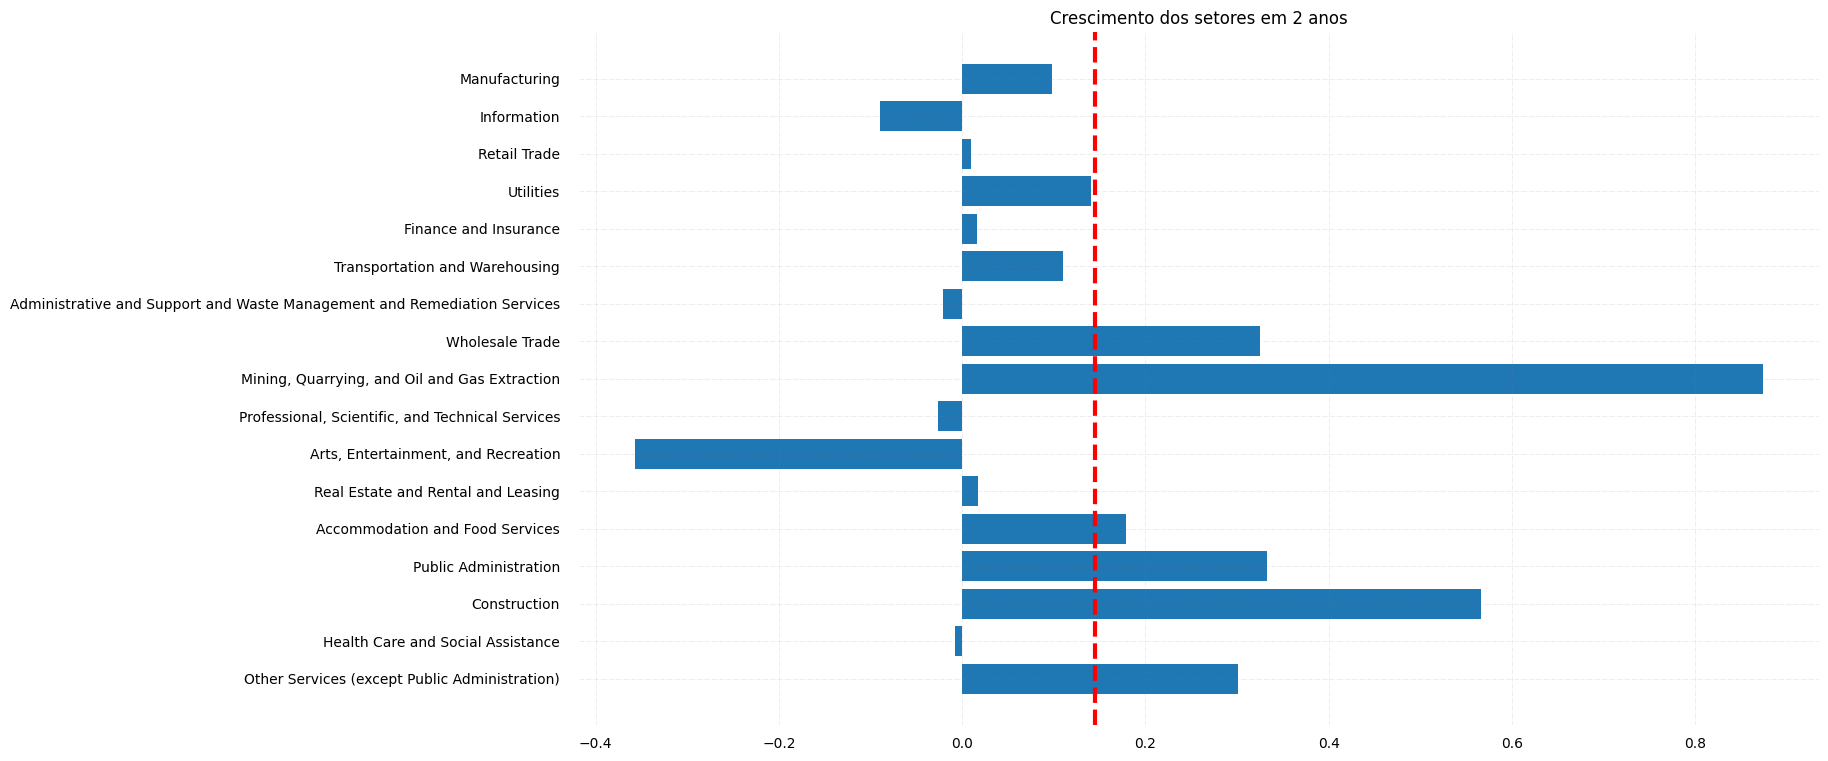

In [282]:
plotting(sectors_growth["Sectors"], sectors_growth["Growth-2years"], "2 anos") ## linha vermelha representa a media

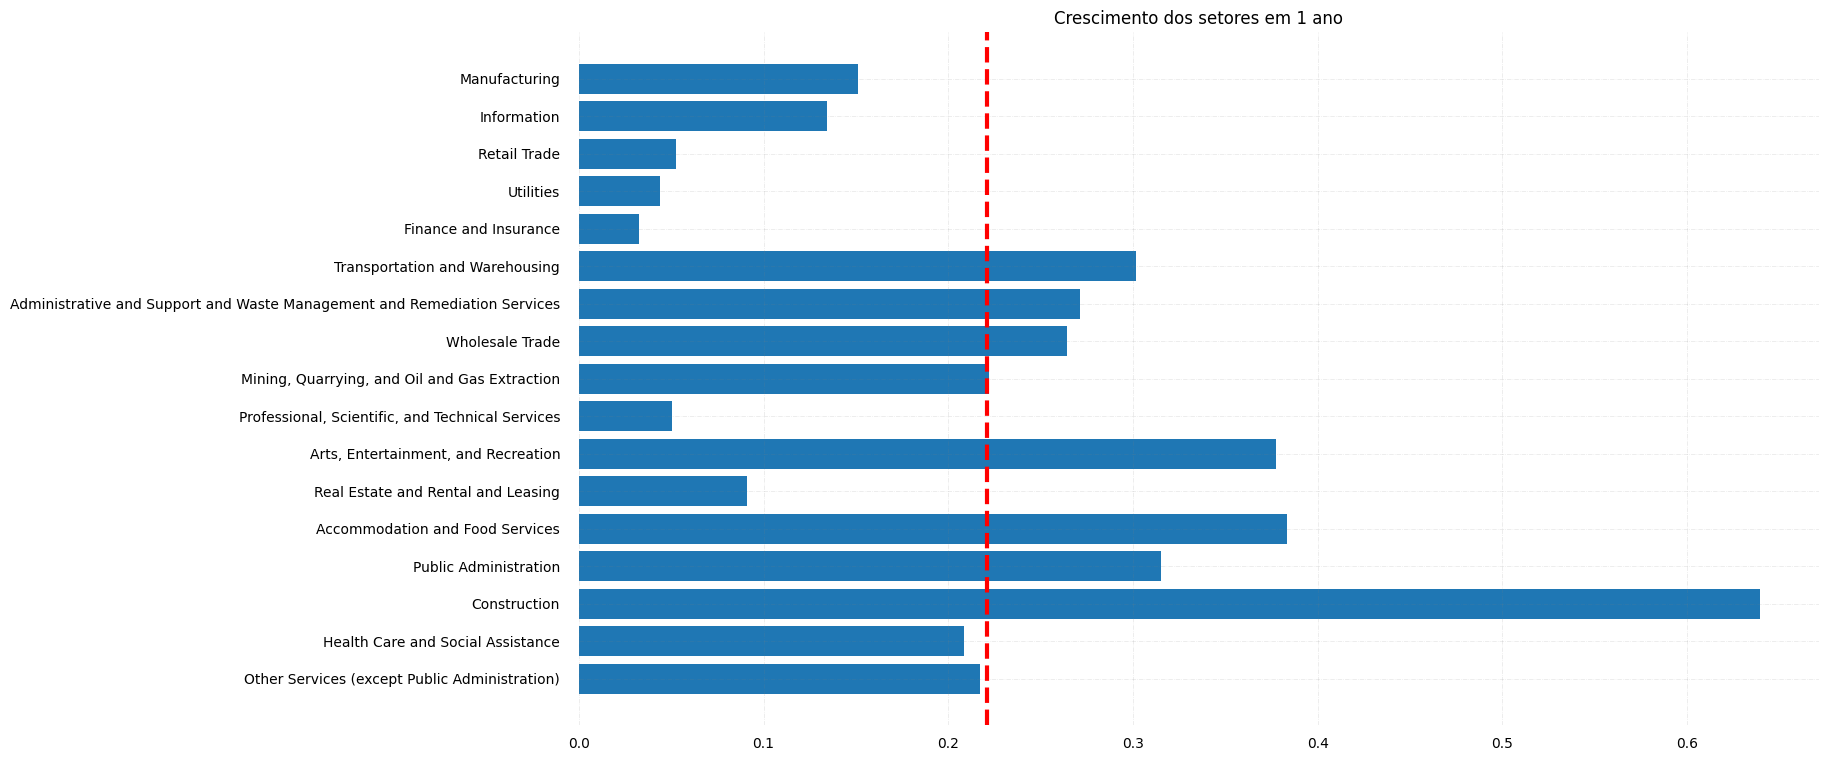

In [283]:
plotting(sectors_growth["Sectors"], sectors_growth["Growth-1year"], "1 ano")

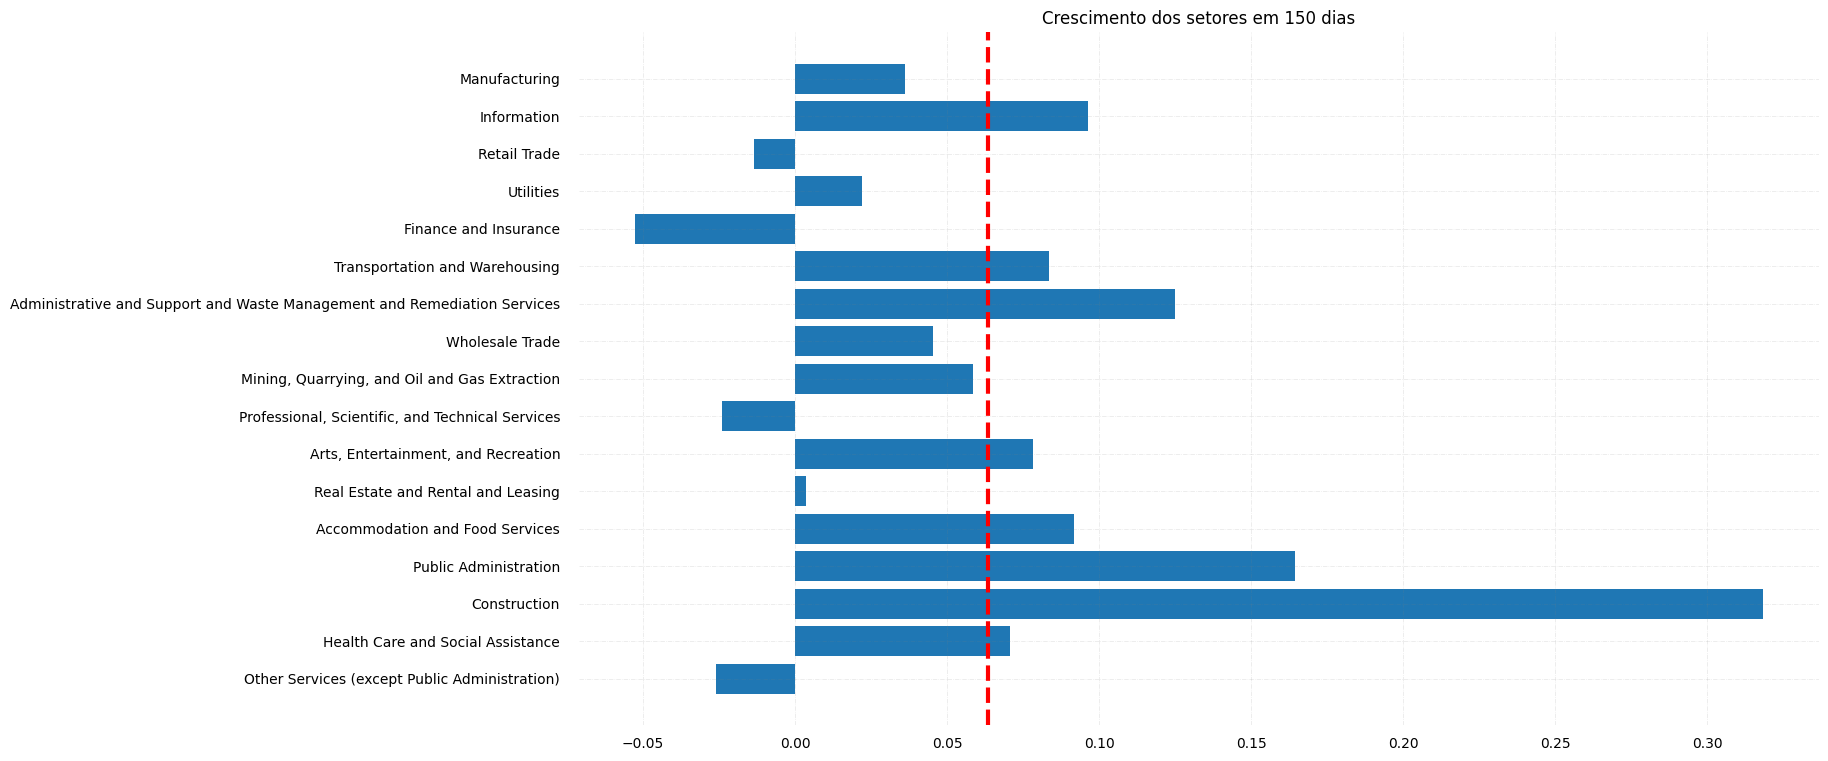

In [284]:
plotting(sectors_growth["Sectors"], sectors_growth["Growth-150days"], "150 dias")

Percebe-se que os setores que mais se destacam são o de Construção(5), Transporte(18), Atacado(15), portanto farei uma analise mais profunda em cada um desses setores, começando pela Construção

Pegando as 50 melhores ações de acordo com o método quantitativo escolhido.

In [285]:
rv_dataframe[rv_dataframe.isnull().any(axis=1)] # Lidando com valores NaN

,Ticker,Price,Number of Shares to Buy,Price-to-Earning Ratio,PE Percentile,Price-to-book Ratio,PB Percentile,Price-to-sales Ratio,PS Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score,sector,2yearGrowth,1yearGrowth,150dayGrowth
23,GOOG,122.79,NaN,None,N/A,None,N/A,None,N/A,NaN,N/A,NaN,N/A,N/A,Information,-0.109029,0.134738,0.264573
26,AMCR,10.18,NaN,15.49,N/A,3.5,N/A,0.9964,N/A,10.382326,N/A,7.624346,N/A,N/A,None,-0.021857,-0.165454,-0.095006
42,AON,343.21,NaN,None,N/A,None,N/A,None,N/A,NaN,N/A,NaN,N/A,N/A,Finance and Insurance,0.498078,0.229842,0.09133
64,BRK.B,347.58,NaN,None,N/A,None,N/A,None,N/A,NaN,N/A,NaN,N/A,N/A,Finance and Insurance,0.248088,0.206917,0.122566
152,DIS,85.63,NaN,38.06,N/A,1.62,N/A,1.82,N/A,14.880540,N/A,6.832653,N/A,N/A,None,-0.513853,-0.166131,-0.21613
196,FRT,102.29,NaN,None,N/A,None,N/A,None,N/A,NaN,N/A,NaN,N/A,N/A,None,-0.048161,0.036802,-0.048334
208,FOX,30.98,NaN,None,N/A,None,N/A,None,N/A,NaN,N/A,NaN,N/A,N/A,Information,-0.06242,-0.036279,-0.091456
228,PEAK,22.01,NaN,21.79,N/A,1.83,N/A,5.79,N/A,10.138870,N/A,5.793458,N/A,N/A,None,-0.339679,-0.135537,-0.143062
265,J,126.21,NaN,None,N/A,None,N/A,None,N/A,NaN,N/A,NaN,N/A,N/A,"Professional, Scientific, and Technical Services",-0.043156,-0.022377,0.032513
275,KIM,20.60,NaN,None,N/A,None,N/A,None,N/A,NaN,N/A,NaN,N/A,N/A,None,0.068566,0.001404,-0.009422


In [286]:
for column in ['Price-to-Earning Ratio',
                'Price-to-book Ratio',
            'Price-to-sales Ratio', 'EV/EBITDA',
            'EV/GP']:
  rv_dataframe[column].fillna(rv_dataframe[column].mean(), inplace=True) ## os valores que forem NaN vão receber a media das outras métricas

In [287]:
from scipy.stats import percentileofscore as score

metricas = { ## dicionario
    'Price-to-Earning Ratio':'PE Percentile',
    'Price-to-book Ratio':'PB Percentile',
    'Price-to-sales Ratio':'PS Percentile',
    'EV/EBITDA':'EV/EBITDA Percentile',
    'EV/GP':'EV/GP Percentile',

}
for metric in metricas.keys(): ## percore pelas chaves do dicionario(price-to-earning  etc .. )
  for row in rv_dataframe.index: ## percore todas as linhas do data frame
    rv_dataframe.loc[row, metricas[metric]] = score(rv_dataframe[metric], rv_dataframe.loc[row, metric])
## para cada linha, entra na coluna dos percentiles e calcula o score
## score = porcentagem em comparação aos outros, ex: se o numero for maior que 80%
## dos outros valores da coluna, então recebe 80%



In [288]:
from statistics import mean

for row in rv_dataframe.index: ## percorre todas as linhas do tada frame
  value_percentiles = [] ## lista para pegar todas as procentagens da linha
  for metric in metricas.keys():
    value_percentiles.append(rv_dataframe.loc[row, metricas[metric]]) ## adicionando todas as porcentagens na lista


  rv_dataframe.loc[row, 'RV Score'] = mean(value_percentiles) ## rv score da linha = media das porcentagens

In [289]:
rv_dataframe.sort_values('RV Score', ascending=True, inplace=True) # ordenando o data frame pelo RV Score

In [290]:
rv_dataframe = rv_dataframe[(rv_dataframe['Price-to-Earning Ratio']>0) & (rv_dataframe['Price-to-book Ratio']>0) & (rv_dataframe['EV/EBITDA'] > 0) & (rv_dataframe['EV/GP'] > 0)]
#removendo valores negativos.
#removo esses valores pois evidenciam que a empresa não esta indo bem.
#A exemplo, se a price-to-earning for negativa, quer dizer que a empresa está com prejuízo.

In [291]:
top50_dataframe = rv_dataframe[:50] # pegando as 50 ações com menor score

In [292]:
rv_dataframe.reset_index(drop=True, inplace=True)

Análise com o setor Construção:

In [293]:
construction_df = rv_dataframe[rv_dataframe["sector"] == "Construction"]

In [294]:
construction_df

,Ticker,Price,Number of Shares to Buy,Price-to-Earning Ratio,PE Percentile,Price-to-book Ratio,PB Percentile,Price-to-sales Ratio,PS Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score,sector,2yearGrowth,1yearGrowth,150dayGrowth
35,PHM,83.42,NaN,7.19,13.8,1.89,28.6,1.05,16.0,5.079552,8.2,3.704419,25.6,18.44,Construction,0.58132,0.889437,0.477627
49,LEN,127.54,NaN,8.69,16.6,1.45,18.1,1.08,17.2,6.229672,11.0,5.708246,36.4,19.86,Construction,0.279233,0.586377,0.240147
62,DHI,131.00,NaN,8.82,17.0,2.14,33.2,1.32,23.3,6.827558,13.0,4.726280,30.8,23.46,Construction,0.429902,0.757154,0.323083
141,NVR,6361.13,NaN,13.38,24.6,5.26,66.2,1.95,36.9,8.603875,19.4,6.658344,45.6,38.54,Construction,0.239979,0.424719,0.232548
332,PWR,205.40,NaN,60.59,90.0,5.37,67.0,1.69,32.0,27.802928,88.0,13.113887,85.2,72.44,Construction,1.297841,0.539611,0.317867


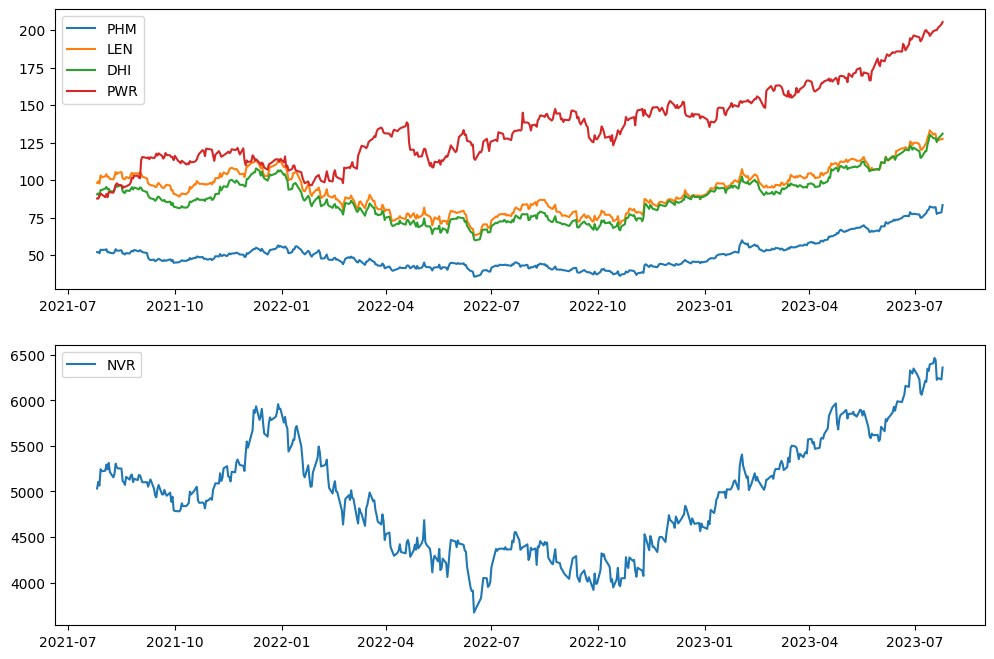

<Figure size 1200x1200 with 0 Axes>

In [295]:
Stocks_df = pd.DataFrame()


fig, axs = plt.subplots(2, figsize=(12,8))
plt.figure(figsize=(12,12))
for ind in construction_df.index:
  Ticker = construction_df["Ticker"][ind]
  if Ticker != "NVR":
    info = yf.Ticker(Ticker)
    hist = info.history(period="2y")["Close"]
    Stocks_df[f"{Ticker}"] = hist

    axs[0].plot(hist, label = f'{Ticker}')
    axs[0].legend()
    time.sleep(0.5)



info = yf.Ticker("NVR")
hist = info.history(period="2y")["Close"]
Stocks_df["NVR"] = hist
axs[1].plot(hist, label = "NVR")
axs[1].legend()

Estudando a correlação entre as ações

In [296]:
 corr_df =  Stocks_df.corr(method='pearson')
 corr_df.head().reset_index()
 corr_df.head(10)

,PHM,LEN,DHI,PWR,NVR
PHM,1.000000,0.919007,0.944723,0.623368,0.923211
LEN,0.919007,1.000000,0.984397,0.427453,0.963397
DHI,0.944723,0.984397,1.000000,0.520884,0.957542
PWR,0.623368,0.427453,0.520884,1.000000,0.389781
NVR,0.923211,0.963397,0.957542,0.389781,1.000000


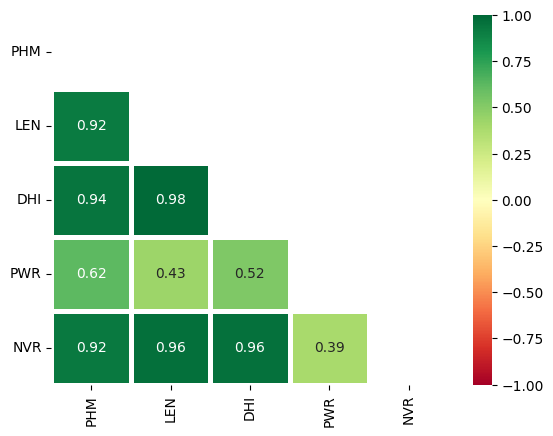

In [297]:
 mask = np.zeros_like(corr_df)
 mask[np.triu_indices_from(mask)] = True
 sns.heatmap(corr_df, cmap='RdYlGn', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5, annot=True)
 plt.yticks(rotation=0)
 plt.xticks(rotation=90)
 plt.show()

Perceb-se a grande correlação entre as ações menos a Quanta Services, Inc. (PWR), isto devido ao crescimento maior comparado as outras ações

In [298]:
best_construction = top50_dataframe[top50_dataframe.sector == "Construction"] ## pegando as melhores empresas com o score quantitativo

In [299]:
best_construction

,Ticker,Price,Number of Shares to Buy,Price-to-Earning Ratio,PE Percentile,Price-to-book Ratio,PB Percentile,Price-to-sales Ratio,PS Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score,sector,2yearGrowth,1yearGrowth,150dayGrowth
387,PHM,83.42,NaN,7.19,13.8,1.89,28.6,1.05,16.0,5.079552,8.2,3.704419,25.6,18.44,Construction,0.58132,0.889437,0.477627
286,LEN,127.54,NaN,8.69,16.6,1.45,18.1,1.08,17.2,6.229672,11.0,5.708246,36.4,19.86,Construction,0.279233,0.586377,0.240147


Portanto, PHM será responsável por 30% desse protifólio, haja vista que está em um setor de alto crescimento, e segundo as métricas quantitativas, ainda é uma ótima empresa a ser investida


Transporte


In [300]:
transportation_df = rv_dataframe[rv_dataframe["sector"] == "Transportation and Warehousing"]

In [314]:
transportation_df

,Ticker,Price,Number of Shares to Buy,Price-to-Earning Ratio,PE Percentile,Price-to-book Ratio,PB Percentile,Price-to-sales Ratio,PS Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score,sector,2yearGrowth,1yearGrowth,150dayGrowth
11,UAL,54.22,NaN,6.74,13.0,2.39,38.9,0.3613,4.0,3.846649,4.4,0.587838,1.0,12.26,Transportation and Warehousing,0.140753,0.49202,0.086355
39,DAL,46.44,NaN,9.99,18.6,3.77,55.5,0.5480,6.6,6.176589,10.6,0.802169,2.8,18.82,Transportation and Warehousing,0.151634,0.481615,0.192659
54,FDX,259.66,NaN,16.73,33.8,2.49,40.0,0.7210,10.4,8.274409,18.8,0.873193,3.4,21.28,Transportation and Warehousing,-0.092365,0.164892,0.232516
89,LUV,35.53,NaN,34.83,74.8,2.15,33.7,0.8917,13.4,8.125535,18.0,0.744933,2.2,28.42,Transportation and Warehousing,-0.288079,-0.111414,0.005296
90,ALK,48.18,NaN,104.76,96.4,1.85,27.8,0.6713,8.8,6.021914,10.0,0.635320,1.2,28.84,Transportation and Warehousing,-0.172876,0.101509,-0.041575
101,UPS,184.69,NaN,14.93,28.8,6.81,75.5,1.3800,23.9,9.544496,23.2,1.509784,8.4,31.96,Transportation and Warehousing,-0.072368,0.017981,0.00678
106,KMI,18.06,NaN,15.98,32.0,1.31,16.2,2.1500,42.0,9.907374,24.4,6.991102,49.4,32.8,Transportation and Warehousing,0.176899,0.066952,0.009345
117,EXPD,125.45,NaN,16.31,32.9,6.07,71.4,1.2700,21.9,9.861419,24.2,3.968707,27.4,35.56,Transportation and Warehousing,-0.015678,0.280311,0.111267
128,JBHT,199.76,NaN,22.70,51.4,5.41,68.0,1.4100,24.7,11.173094,29.8,1.597012,9.2,36.62,Transportation and Warehousing,0.214704,0.163131,0.040729
149,TRGP,81.67,NaN,21.16,46.6,7.21,76.8,0.8976,13.8,8.711689,20.0,6.332701,42.4,39.92,Transportation and Warehousing,0.992635,0.301215,0.074807


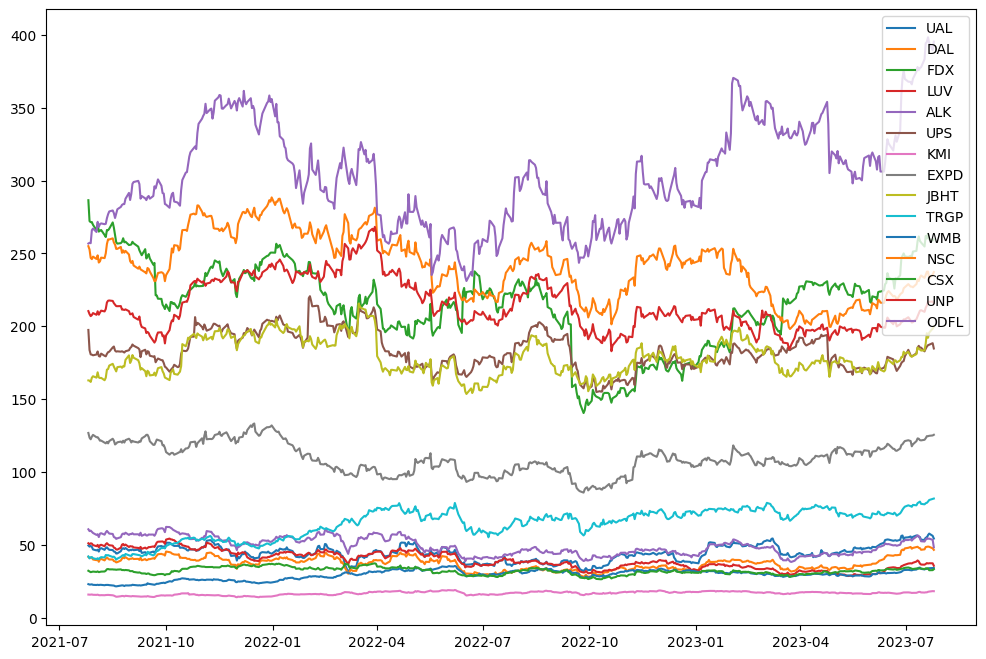

In [302]:
Stocks_df = pd.DataFrame()


plt.figure(figsize=(12,8))
for ind in transportation_df.index:
  Ticker = transportation_df["Ticker"][ind]
  if Ticker != "NVR":
    info = yf.Ticker(Ticker)
    hist = info.history(period="2y")["Close"]
    Stocks_df[f"{Ticker}"] = hist
    plt.plot(hist, label = f'{Ticker}')
    plt.legend()
    time.sleep(0.5)


In [303]:
 corr_df =  Stocks_df.corr(method='pearson')
 corr_df.head().reset_index()
 corr_df.head(10)

,UAL,DAL,FDX,LUV,ALK,UPS,KMI,EXPD,JBHT,TRGP,WMB,NSC,CSX,UNP,ODFL
UAL,1.000000,0.871430,0.402371,0.253439,0.600986,0.106743,0.021655,0.585242,0.250326,0.104458,-0.072567,0.107270,0.349417,-0.049327,0.555224
DAL,0.871430,1.000000,0.512418,0.572991,0.833579,0.292089,-0.117041,0.606946,0.346495,-0.107081,-0.164490,0.396829,0.550964,0.248693,0.438485
FDX,0.402371,0.512418,1.000000,0.425748,0.518341,0.543829,-0.478172,0.705402,0.281346,-0.446144,-0.496107,0.297861,0.499143,0.287142,0.389908
LUV,0.253439,0.572991,0.425748,1.000000,0.829546,0.384778,-0.422811,0.393797,0.213222,-0.646117,-0.471446,0.699536,0.478273,0.496030,-0.119164
ALK,0.600986,0.833579,0.518341,0.829546,1.000000,0.462816,-0.342196,0.541165,0.412772,-0.436707,-0.442933,0.653683,0.614530,0.473768,0.218251
UPS,0.106743,0.292089,0.543829,0.384778,0.462816,1.000000,-0.230587,0.394491,0.758951,-0.196009,-0.221095,0.675897,0.729431,0.770275,0.464887
KMI,0.021655,-0.117041,-0.478172,-0.422811,-0.342196,-0.230587,1.000000,-0.443906,-0.050969,0.873390,0.907060,-0.255930,-0.128589,-0.097915,-0.085794
EXPD,0.585242,0.606946,0.705402,0.393797,0.541165,0.394491,-0.443906,1.000000,0.436874,-0.427108,-0.522333,0.415694,0.536476,0.136328,0.621578
JBHT,0.250326,0.346495,0.281346,0.213222,0.412772,0.758951,-0.050969,0.436874,1.000000,0.014618,-0.049943,0.688799,0.757066,0.683790,0.670549
TRGP,0.104458,-0.107081,-0.446144,-0.646117,-0.436707,-0.196009,0.873390,-0.427108,0.014618,1.000000,0.896668,-0.398672,-0.115081,-0.142714,0.163758


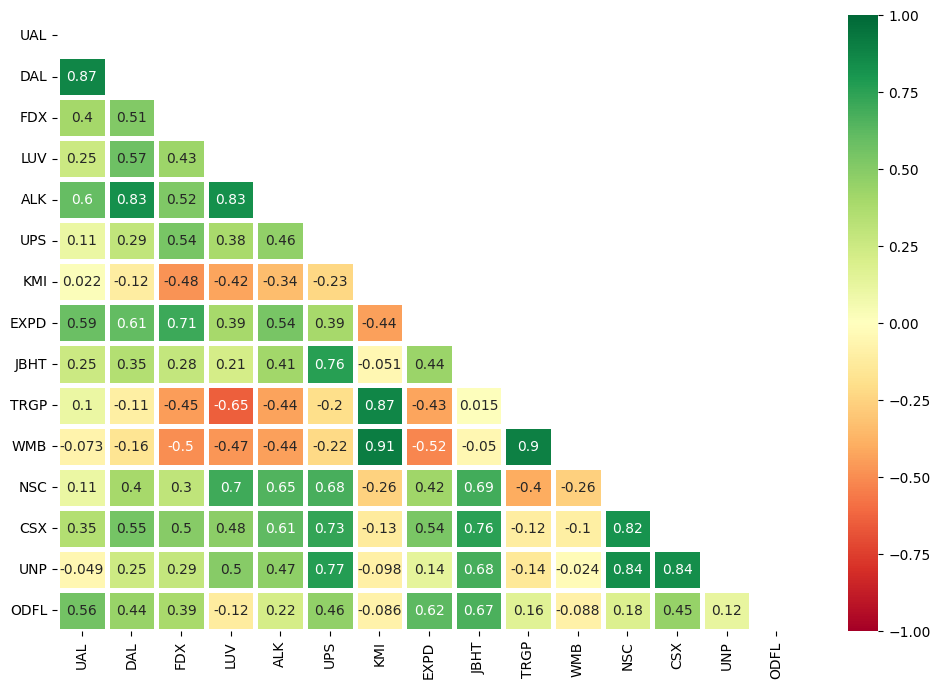

In [304]:
 mask = np.zeros_like(corr_df)
 mask[np.triu_indices_from(mask)] = True
 plt.figure(figsize=(12,8))
 sns.heatmap(corr_df, cmap='RdYlGn', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5, annot=True)

 plt.yticks(rotation=0)
 plt.xticks(rotation=90)
 plt.show()

Percebe-se que KMI, TRGP, WMB tem um correlação negativa a quase todas as outras empresas no ramo

In [305]:
best_transportation = top50_dataframe[top50_dataframe.sector == "Transportation and Warehousing"]

In [306]:
best_transportation

,Ticker,Price,Number of Shares to Buy,Price-to-Earning Ratio,PE Percentile,Price-to-book Ratio,PB Percentile,Price-to-sales Ratio,PS Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score,sector,2yearGrowth,1yearGrowth,150dayGrowth
459,UAL,54.22,NaN,6.74,13.0,2.39,38.9,0.3613,4.0,3.846649,4.4,0.587838,1.0,12.26,Transportation and Warehousing,0.140753,0.49202,0.086355
144,DAL,46.44,NaN,9.99,18.6,3.77,55.5,0.5480,6.6,6.176589,10.6,0.802169,2.8,18.82,Transportation and Warehousing,0.151634,0.481615,0.192659


Temos que a UAL e DAL são as empresas com melhores scores no nosso método, portanto aprofundarei a pesquisa nessas duas

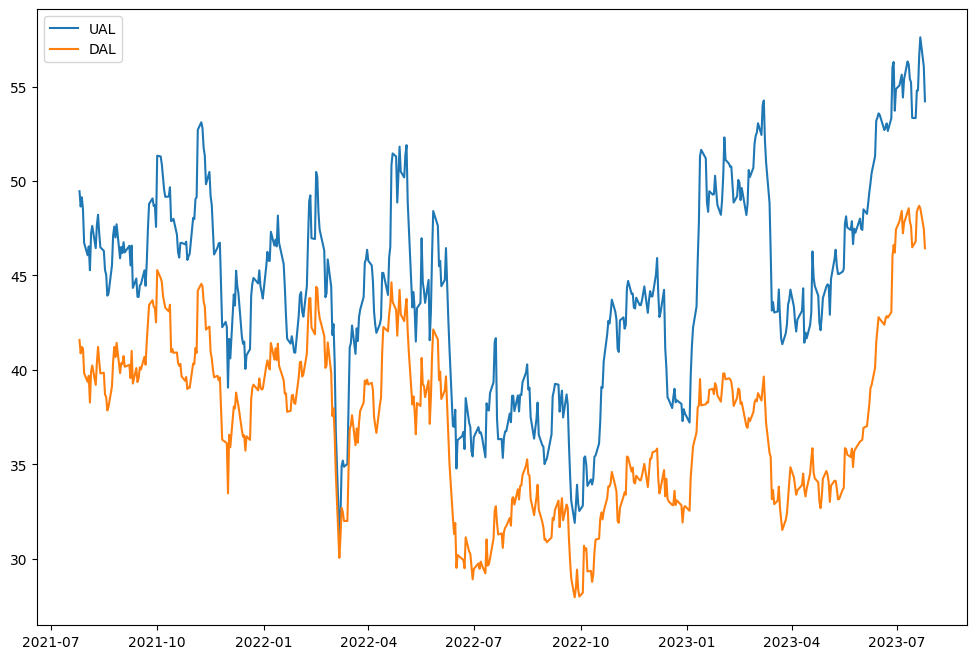

In [307]:
plt.figure(figsize=(12,8))
for ind in best_transportation.index:
  Ticker = best_transportation["Ticker"][ind]
  info = yf.Ticker(Ticker)
  hist = info.history(period="2y")["Close"]
  Stocks_df[f"{Ticker}"] = hist
  plt.plot(hist, label = f'{Ticker}')
  plt.legend()
  time.sleep(0.5)

Percebe-se a grande correlação entre as duas ações, movimentos praticamente iguais

Portanto, o portifólio ira conter 20% de cada uma dessas empresas

Análise no setor de Wholesale(Atacados)

In [308]:
wholesale = rv_dataframe[rv_dataframe.sector == "Wholesale Trade"]

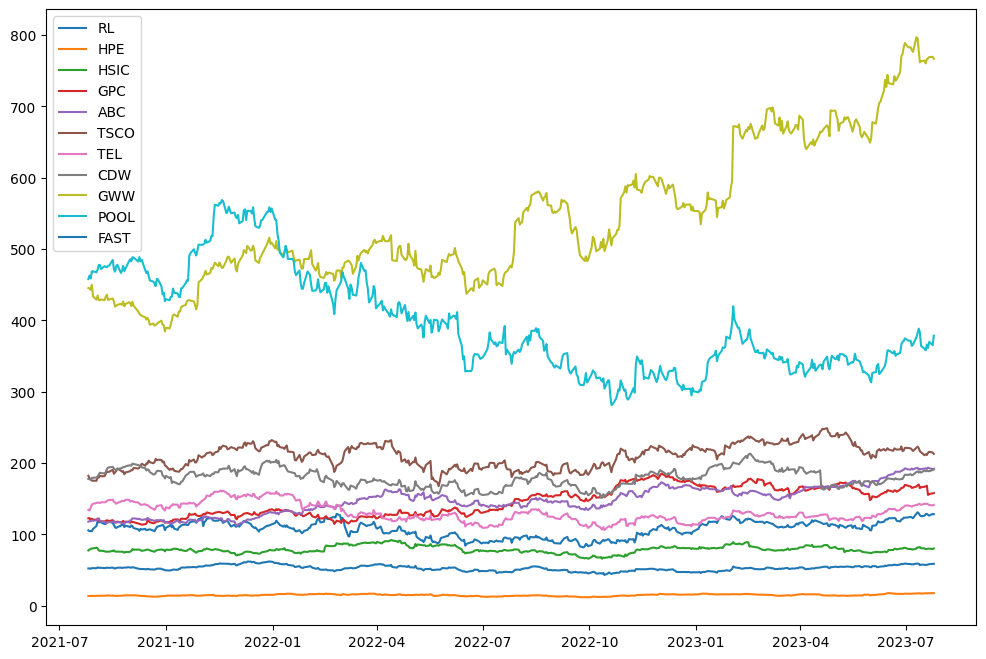

In [309]:
Stocks_df = pd.DataFrame()


plt.figure(figsize=(12,8))
for ind in wholesale.index:
  Ticker = wholesale["Ticker"][ind]
  if Ticker != "CMG":
    info = yf.Ticker(Ticker)
    hist = info.history(period="2y")["Close"]
    Stocks_df[f"{Ticker}"] = hist
    plt.plot(hist, label = f'{Ticker}')
    plt.legend()
    time.sleep(0.5)


In [310]:
 corr_df =  Stocks_df.corr(method='pearson')
 corr_df.head().reset_index()
 corr_df.head(10)

,RL,HPE,HSIC,GPC,ABC,TSCO,TEL,CDW,GWW,POOL,FAST
RL,1.000000,0.671152,0.394670,0.035734,0.166481,0.550828,0.587273,0.662288,0.344814,0.374300,0.566594
HPE,0.671152,1.000000,0.602846,0.224947,0.532083,0.527969,0.253922,0.454089,0.452310,0.055776,0.429733
HSIC,0.394670,0.602846,1.000000,-0.049576,0.330551,0.345497,-0.005071,0.165698,0.105081,0.093990,0.242220
GPC,0.035734,0.224947,-0.049576,1.000000,0.739962,0.452894,-0.462123,0.123968,0.804926,-0.743089,-0.221369
ABC,0.166481,0.532083,0.330551,0.739962,1.000000,0.456436,-0.477917,-0.088662,0.847982,-0.683764,0.000893
TSCO,0.550828,0.527969,0.345497,0.452894,0.456436,1.000000,0.089117,0.397542,0.598289,-0.022114,0.443299
TEL,0.587273,0.253922,-0.005071,-0.462123,-0.477917,0.089117,1.000000,0.616462,-0.205585,0.861828,0.724298
CDW,0.662288,0.454089,0.165698,0.123968,-0.088662,0.397542,0.616462,1.000000,0.191472,0.386711,0.427542
GWW,0.344814,0.452310,0.105081,0.804926,0.847982,0.598289,-0.205585,0.191472,1.000000,-0.536836,0.204894
POOL,0.374300,0.055776,0.093990,-0.743089,-0.683764,-0.022114,0.861828,0.386711,-0.536836,1.000000,0.638752


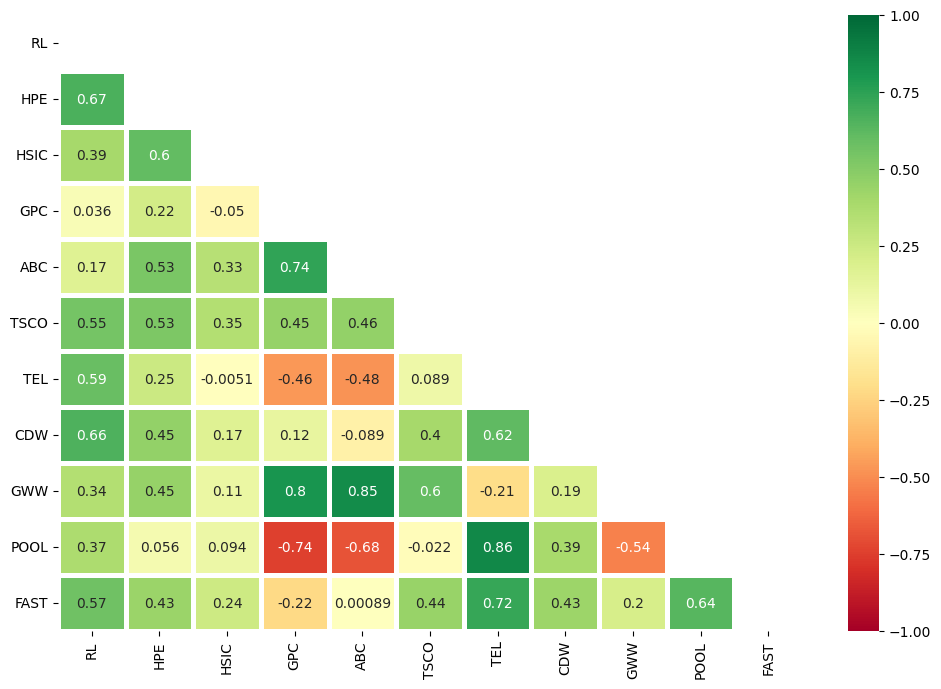

In [311]:
 mask = np.zeros_like(corr_df)
 mask[np.triu_indices_from(mask)] = True
 plt.figure(figsize=(12,8))
 sns.heatmap(corr_df, cmap='RdYlGn', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5, annot=True)

 plt.yticks(rotation=0)
 plt.xticks(rotation=90)
 plt.show()

percebe-se tambem a grande correlacao entre as empresas, tirando a TEL e a POOL

In [312]:
best_wholesale = top50_dataframe[top50_dataframe.sector == "Wholesale Trade"]

In [313]:
best_wholesale

,Ticker,Price,Number of Shares to Buy,Price-to-Earning Ratio,PE Percentile,Price-to-book Ratio,PB Percentile,Price-to-sales Ratio,PS Percentile,EV/EBITDA,EV/EBITDA Percentile,EV/GP,EV/GP Percentile,RV Score,sector,2yearGrowth,1yearGrowth,150dayGrowth
392,RL,128.15,NaN,16.91,34.6,2.14,33.2,0.8055,11.8,5.216725,8.4,1.223973,5.6,18.72,Wholesale Trade,0.230586,0.362323,0.04972


Investimento na Ralph Lauren

Portanto, o portifólio final ficará - 30% ralph lauren 20%- delta 20%- UAL 30%- PHM

O preço de cada uma no final do dia 25 de agosto é o seguinte:

Ralph Lauren(RL) - 115.15

Delta(DAL) - 42.00

United Airlines(UAL) - 49.22

PulteGroup(PHM) - 82.00


Preço 23/01/2024

Ralph Lauren(RL) - 140.00 -> +21%

Delta(DAL) - 38.00 -> -10%

United Airlines (UAL) - 40.81 -> -17%

PulteGroup(PHM) - 104 -> + 26.8%

No total, após 5 meses: +8.9 %